In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")


Detected Linux: defaulting to Torch backend
Final Keras backend: Torch


In [ ]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()


GPU available: Tesla T4
Using GPU


In [3]:
# Inputting the data
df = pd.read_csv('../../Data/household_power_consumption.txt', sep=';')
display(df.head())




/var/folders/k7/8yrsgrc16mg4bcd162_v2wlr0000gn/T/ipykernel_91794/3982251599.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../Data/household_power_consumption.txt', sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


# Exploratory Data Analysis

## Variables in Dataset

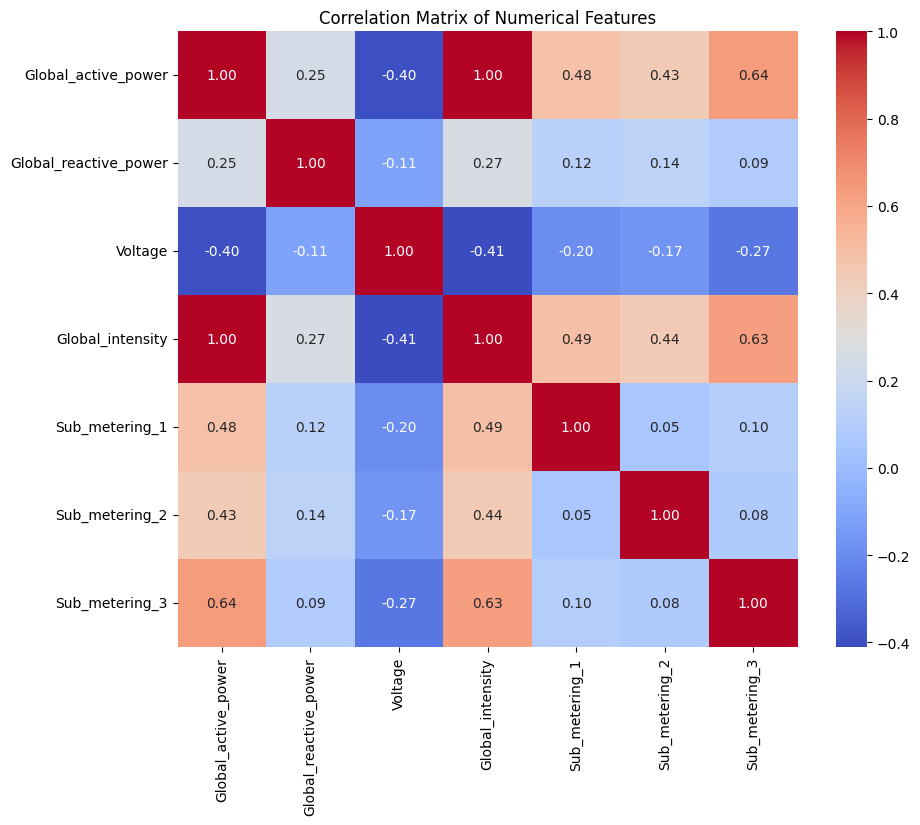

In [4]:
# Convert relevant columns to numeric, coercing errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Calculate the correlation matrix
corr_matrix = df.select_dtypes(include=np.number).corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [5]:
#Look at the missing values
df.isnull().sum()

#Fill with the forward fill method
df.fillna(method='ffill', inplace=True)


/var/folders/k7/8yrsgrc16mg4bcd162_v2wlr0000gn/T/ipykernel_91794/1551451548.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

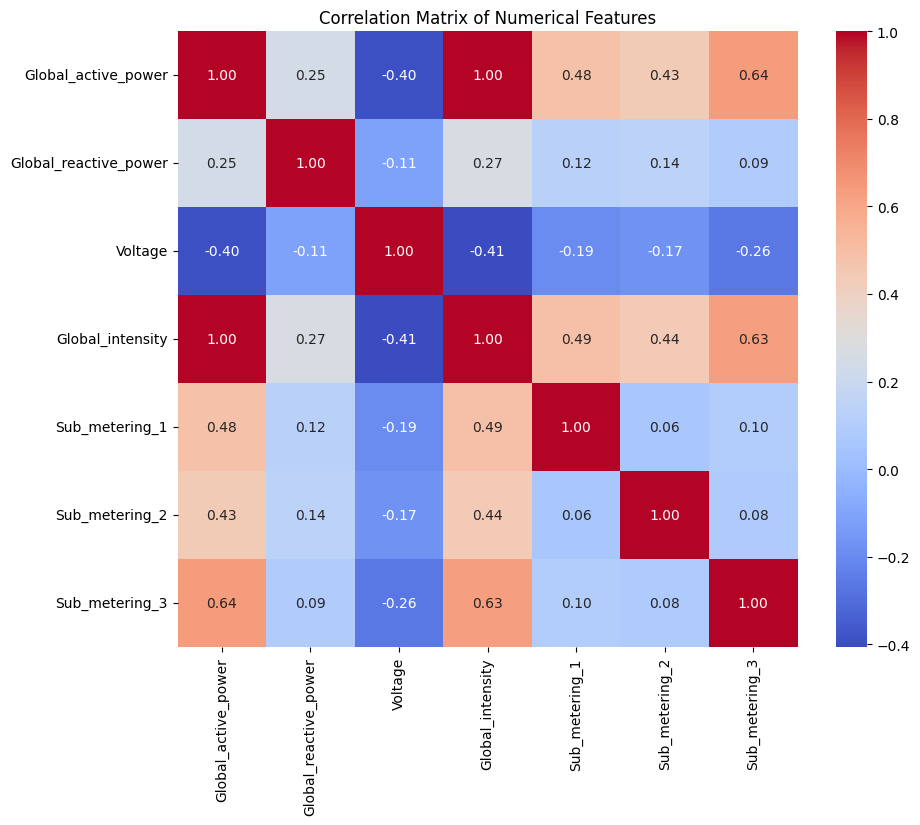

In [7]:
# Convert relevant columns to numeric, coercing errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate the correlation matrix
corr_matrix = df.select_dtypes(include=np.number).corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#Global Intensity and active power are perfect, weird.

In [8]:

#Converting to datetime for time series analysis
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format = "%d/%m/%Y %H:%M:%S")
df.drop(['Date', 'Time'], axis = 1, inplace = True)

#order the values by datetime
df.sort_values('datetime', inplace=True)

#make datetime the index
df.set_index('datetime', inplace=True)

#order

In [9]:
#Note the Data spans from 2006-12-16 to 2010-11-26, and is recorded every minute. We want to resample to to every hour.
df_hour = df.resample('h').mean()




In [10]:
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,1.086200,0.894942,0.124000,0.341267,0.799533,1.574967,6.560533
Global_reactive_power,34589.0,0.123326,0.067221,0.000000,0.077667,0.106767,0.149367,0.774333
Voltage,34589.0,240.841505,2.999127,225.834500,239.197167,240.984500,242.691833,251.902000
Global_intensity,34589.0,4.604360,3.746337,0.503333,1.510000,3.406667,6.583333,28.383333
Sub_metering_1,34589.0,1.110951,3.518498,0.000000,0.000000,0.000000,0.000000,48.366667
Sub_metering_2,34589.0,1.287914,4.168720,0.000000,0.000000,0.333333,0.650000,46.433333
Sub_metering_3,34589.0,6.416515,7.344718,0.000000,0.650000,1.650000,14.083333,21.550000


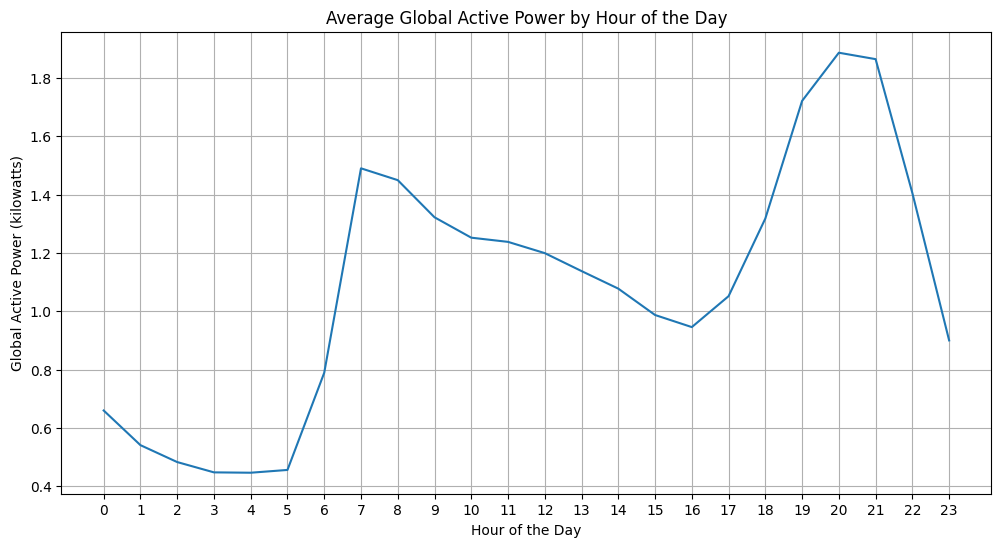

In [11]:
#How does Global Active Power change over each hour of the day?
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hour, x=df_hour.index.hour, y='Global_active_power', errorbar = None)
plt.title('Average Global Active Power by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Global Active Power (kilowatts)')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

- `Low Usage`
    - Hours: 0 to 5
- `Peak Morning Hours`
    - Hours 6 to 8
- `Medium Usage`
    - Hours 9 to 17
- `Peak Evening Hours`
    - Hours 18 to 21
- `Low Usage`
    - Hours 22 to 23

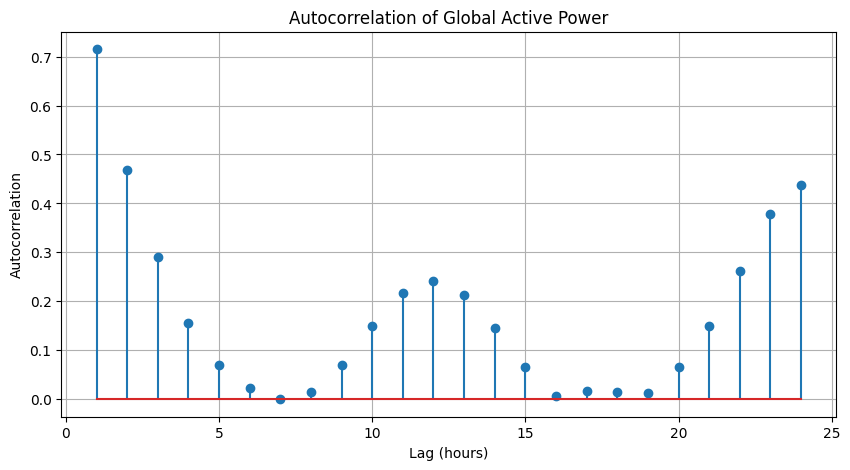

In [ ]:
#Determine the lookback period for sequences, look at the correletion with the lagged values 
lags = range(1, 25)  # Look at lags from 1 to 24 hours
correlations = [df_hour['Global_active_power'].autocorr(lag=lag) for lag in lags] 
#Absolute value of correlations
correlations = [abs(corr) for corr in correlations]  
plt.figure(figsize=(10, 5))
plt.stem(lags, correlations)
plt.title('Autocorrelation of Global Active Power')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

#From the plot, we can see that the highest correlation is at lag 1, 
# and there are significant correlations up to lag 24. Therefore, 
# we will choose a lookback period of 24 hours for our sequences.

### Preprocessing

In [ ]:
#Splitting the data into train, validation, and test sets (70%, 15%, 15%)
# Get the number of samples
n = len(df_hour)

# Compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n)  # 70% + 15%

# Split without shuffling (important for time series!)
train = df_hour.iloc[:train_end]
val = df_hour.iloc[train_end:val_end]
test = df_hour.iloc[val_end:]

print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")
train.head()

Train shape: (11979, 7), Validation shape: (2567, 7), Test shape: (2567, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [ ]:
# Scaling data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()


#Define X_cols:
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity',
          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

train_scaled = train.copy()
train_scaled = scaler_X.fit_transform(train[X_cols])
y_train = scaler_Y.fit_transform(train[['Global_active_power']])

#Recreate dataframe with the datetime column as index
train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=X_cols)


val_scaled = val.copy()

#Scaling the validation and test sets
val_scaled = scaler_X.transform(val[X_cols])
val_y = scaler_Y.transform(val[['Global_active_power']])

#Recreate dataframe with the datetime column as index
val_scaled = pd.DataFrame(val_scaled, index=val.index, columns=X_cols)

test_scaled = test.copy()

test_scaled = scaler_X.transform(test[X_cols])
test_y = scaler_Y.transform(test[['Global_active_power']])

#Recreate dataframe with the datetime column as index
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=X_cols)

In [ ]:
# Shapes of scaled datasets
print(f"Train scaled shape: {train_scaled.shape}, Validation scaled shape: {val_scaled.shape}, Test scaled shape: {test_scaled.shape}")

Train scaled shape: (11979, 6), Validation scaled shape: (2567, 6), Test scaled shape: (2567, 6)


In [ ]:
#Create sliding windows that has a look back of 24hours and predicts 1 hour ahead. This will then allow us to get predictions for every hour
def create_sliding_windows(X, y, look_back=24, forecast_horizon=1):
    X_windows, y_windows = [], []
    for i in range(len(X) - look_back - forecast_horizon + 1):
        X_windows.append(X.iloc[i:i + look_back].values)
        y_windows.append(y[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)

X_train, y_train_windows = create_sliding_windows(train_scaled, y_train)
X_val, y_val_windows = create_sliding_windows(val_scaled, val_y)
X_test, y_test_windows = create_sliding_windows(test_scaled, test_y)

In [ ]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

look_back = 24

# build the LSTM model with 50 units , dense output layer with 1 unit for regression
model = Sequential()
model.add(Input(shape=(look_back, X_train.shape[2]))) # Explicit Input layer
model.add(LSTM(100, activation='relu')) 
model.add(Dense(1))


# compile the model
model.compile(optimizer = "adam", loss = "mse")


# display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch = 5,
                           restore_best_weights=True)



# Train the LSTM model with early stopping
history = model.fit(X_train, y_train_windows,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (X_val, y_val_windows),
                    shuffle = False,
                    callbacks = [early_stop],
                    verbose = 1)

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.3784 - val_loss: 0.2654
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3699 - val_loss: 0.2606
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3596 - val_loss: 0.2595
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.3490 - val_loss: 0.2705
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3415 - val_loss: 0.2656
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3364 - val_loss: 0.2707
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.3319 - val_loss: 0.2635
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3263 - val_loss: 0.2602
Epoch 9/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3214 - val_loss: 0.2640
Epoch 10/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.3151 - val_loss: 0.2621
Epoch 11/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.3066 - val_loss: 0.2692
Epoch 12/20
374/374 ━━━━━━━━━━

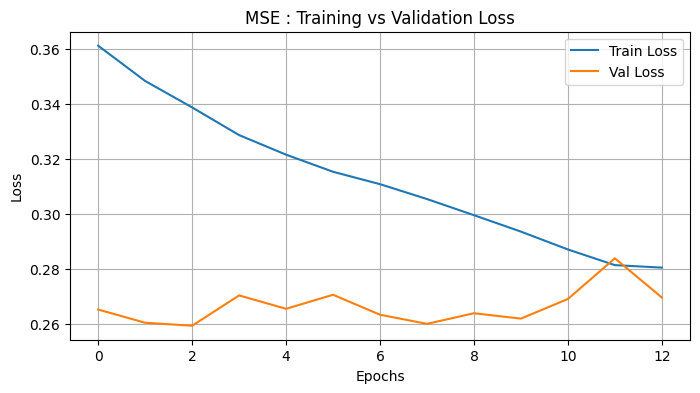

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE : Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Train RMSE: 0.608
Val   RMSE: 0.516
Test  RMSE: 0.551


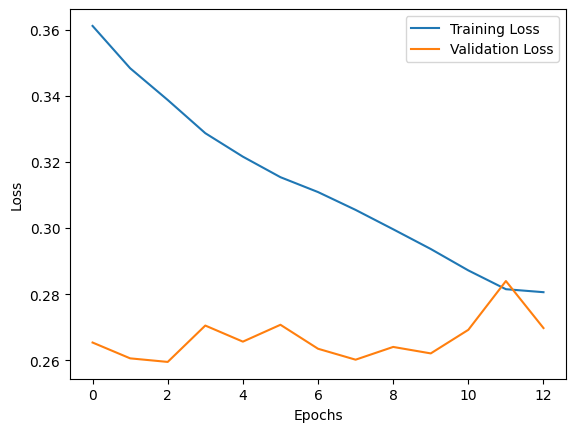

In [ ]:
#Obtain predictions and get the test rmse
#Import root_mean_squared_error and mean_absolute_error from sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error




# Making prediction for each datasets: train, validation, test
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Inverse transform predictions to the original units
train_pred_inv = scaler_Y.inverse_transform(train_pred)
test_pred_inv = scaler_Y.inverse_transform(test_pred)
val_pred_inv = scaler_Y.inverse_transform(val_pred)

# Inverse transform actual target values to the original units
train_y_inv  = scaler_Y.inverse_transform(y_train_windows)
val_y_inv = scaler_Y.inverse_transform(y_val_windows)
test_y_inv = scaler_Y.inverse_transform(y_test_windows)

# Evaluate the model performance
train_rmse = root_mean_squared_error(train_y_inv, train_pred_inv)


test_rmse = root_mean_squared_error(test_y_inv, test_pred_inv)


val_rmse = root_mean_squared_error(val_y_inv, val_pred_inv)



# Print RMSE and MAE for each split
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Val   RMSE: {val_rmse:.3f}")
print(f"Test  RMSE: {test_rmse:.3f}")

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

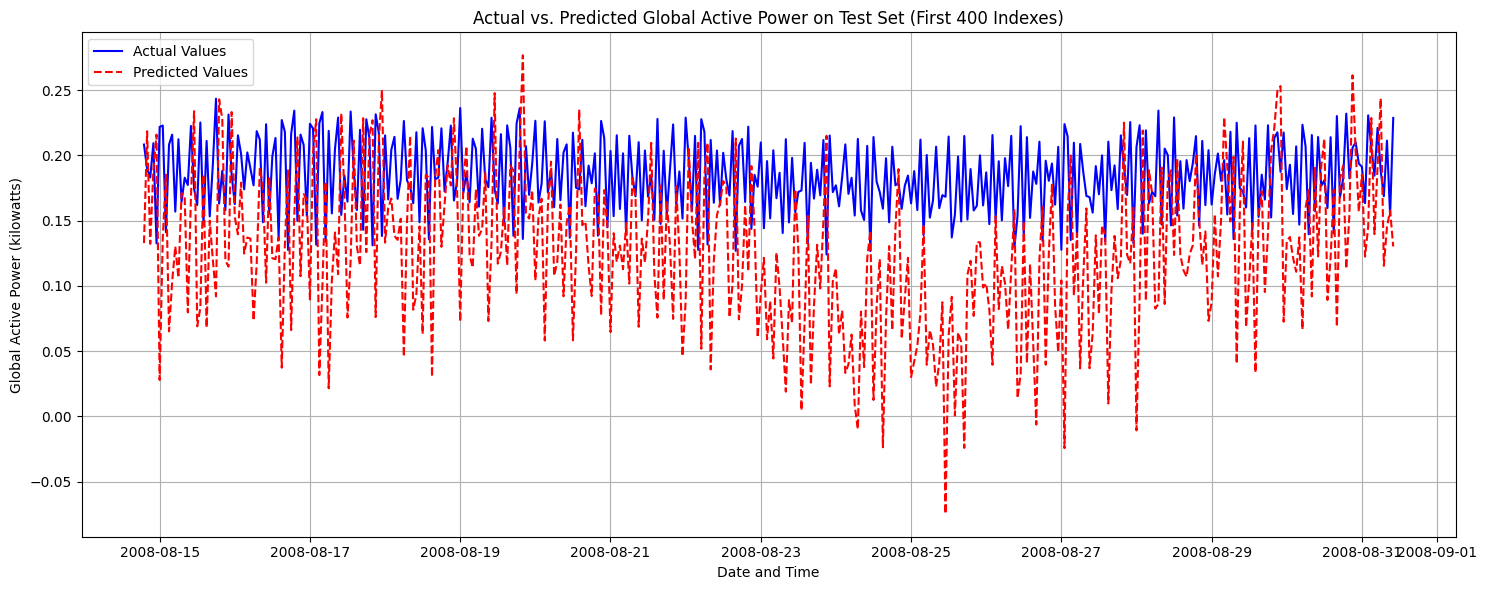

In [ ]:
# Plotting actual vs. predicted values for the test set (first 400 indexes)
plt.figure(figsize=(15, 6))

# Get the datetime index for the predictions
# The y_test_windows starts at index 'look_back' of the original test set
datetime_index_for_plot = test.index[look_back:]

# Plotting only the first 400 data points
plt.plot(datetime_index_for_plot[:400], test_y_inv[:400], label='Actual Values', color='blue')
plt.plot(datetime_index_for_plot[:400], test_pred_inv[:400], label='Predicted Values', color='red', linestyle='--')

plt.title('Actual vs. Predicted Global Active Power on Test Set (First 400 Indexes)')
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

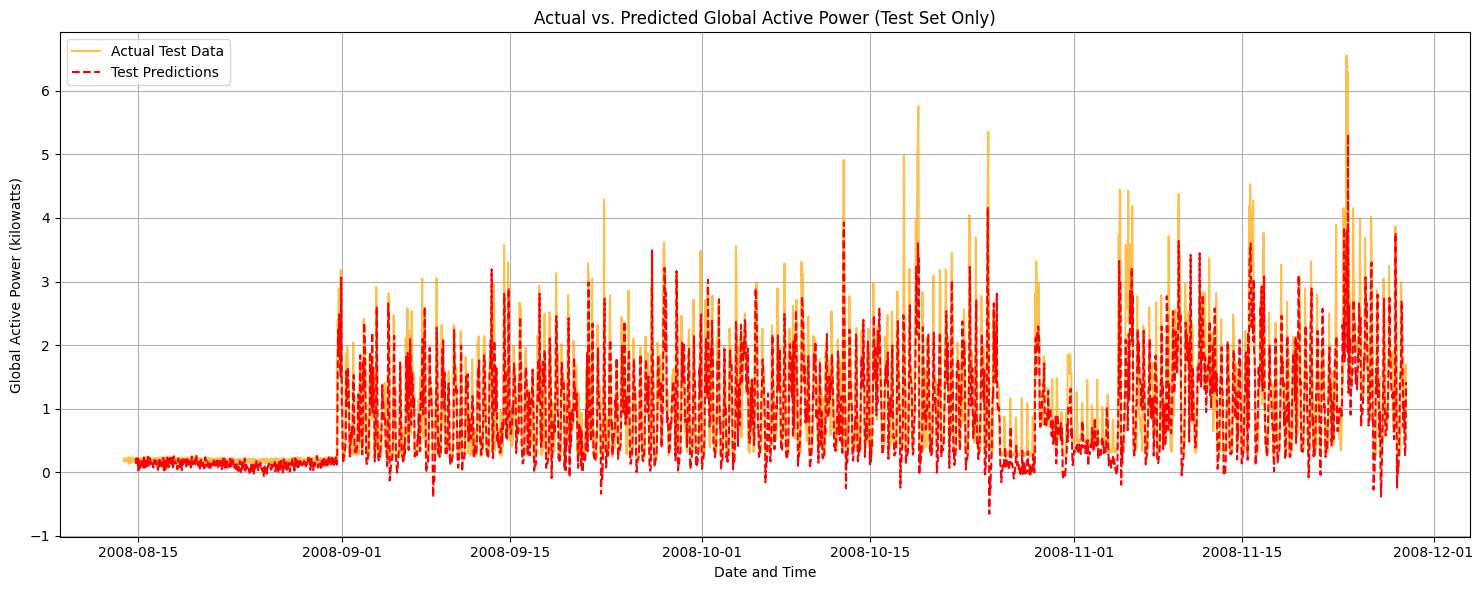

In [ ]:
plt.figure(figsize=(15, 6))

# Plotting Actual Test Data
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='orange', alpha=0.7)

# Plotting Test Predictions
# The test predictions correspond to the data from look_back onwards in the test set
plt.plot(test.index[look_back:], test_pred_inv, label='Test Predictions', color='red', linestyle='--')

plt.title('Actual vs. Predicted Global Active Power (Test Set Only)')
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()